# <div align="center"><b> Swin transformer V2 </b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻


Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:

```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:

```powershell
poetry install
Invoke-Expression (poetry env activate)
```

> 📝 <em><font color='Gray'>Nota:</font></em> Para agregar `pytorch` utilizando Poetry, se utiliza el siguiente comando:
> ```bash
> # Más info: https://github.com/python-poetry/poetry/issues/6409
> poetry source add --priority explicit pytorch_gpu https://download.pytorch.org/whl/cu128 # Seleccionar la wheel adecuada para tu GPU
> poetry add --source pytorch_gpu torch torchvision 
> ```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [1]:
# Recarga automática de módulos en Jupyter Notebook
%reload_ext autoreload
%autoreload 2

# Recarga automática de módulos en Jupyter Notebook
import random
from loguru import logger

import pandas as pd

# PyTorch
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# NumPy y utilidades
import numpy as np
from functools import partial

# Evaluación
import evaluate

# Modelos y procesamiento de imágenes (Transformers)
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    # Swinv2ForImageClassification,  # Descomentar si se usa explícitamente
)
from transformers.integrations import MLflowCallback

import plotly.graph_objects as go
import pandas as pd
from pathlib import Path

from pprint import pprint

from PIL import Image

# Módulos propios
from vision_transformer.plots import show_image_grid, plot_metric, plot_confusion_matrix
from vision_transformer.dataset import load_huggingface_dataset
from vision_transformer.plots import plot_confusion_matrix
from vision_transformer.features import SwinV2Transforms
from vision_transformer.utils import MulticlassAccuracy
from vision_transformer.config import (
    RANDOM_SEED,
    MODELS_DIR,
    FIGURES_DIR,
    MODELS_DIR_SIWNV2_BASE,
    MODELS_DIR_SIWNV2_TINY,
    MODELS_DIR_SIWNV2_LARGE,
    METRICS_FILENAME,
    HISTORY_FILENAME,
    PREDICTIONS_FILENAME,
    MLFLOW_URL,
    DATASET_NAME,
    DATASET_VERSION
)

import mlflow
from mlflow.tracking import MlflowClient
import requests
import sys, os

2025-06-14 20:37:43.641 | INFO     | vision_transformer.config:<module>:15 - PROJ_ROOT path is: E:\Documentos\Git Repositories\vision-transformer
2025-06-14 20:37:43.642 | INFO     | vision_transformer.config:<module>:19 - Actual environment is: dev


🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [ ]:
random.seed(RANDOM_SEED)  # Establece la semilla para la reproducibilidad.
TESTING_MODE = True  # Modo de prueba, si es True, se usa un subconjunto pequeño del dataset.

BATCH_SIZE = 16

# Checkpoints a utilizar
# MODEL_FOLDER = MODELS_DIR_SIWNV2_TINY
# CHECKPOINT = "microsoft/swinv2-tiny-patch4-window8-256"

# MODEL_FOLDER = MODELS_DIR_SIWNV2_BASE
# CHECKPOINT = "microsoft/swinv2-base-patch4-window8-256"

MODEL_FOLDER = MODELS_DIR_SIWNV2_LARGE
CHECKPOINT = "microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft"

# Optimizaciones
# # torch.set_float32_matmul_precision('highest') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'más alta'.
# torch.set_float32_matmul_precision('high') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'alta'.
# # torch.set_float32_matmul_precision('medium') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'media'.
# # torch.backends.cudnn.benchmark = True # Optimización: Para redes CNN (pero como se usa una capa convolucional, se establece en True).

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
logger.info(f"Dispositivo actual: {DEVICE}")

# MLflow: Configuración de la URI de seguimiento
try:
    response = requests.get(MLFLOW_URL)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa.
    logger.success("Conexión a MLflow establecida correctamente.")
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_URL  # Configura la URI de seguimiento de MLflow.
    os.environ["MLFLOW_EXPERIMENT_NAME"] = CHECKPOINT.replace("/", "_")  # Configura el nombre del experimento de MLflow.
    os.environ["MLFLOW_TAGS"] = '{"model_family": "swinv2"}'
except Exception as e:
    logger.error(f"Error al conectar con MLflow. Tienes levantado el servidor de MLflow?")
    raise SystemExit(f"Error al conectar con MLflow: {e}")

2025-06-14 20:37:44.631 | INFO     | __main__:<module>:23 - Dispositivo actual: cuda
2025-06-14 20:37:46.669 | SUCCESS  | __main__:<module>:29 - Conexión a MLflow establecida correctamente.


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | *Fine-tuning* del modelo swimv2 sobre el dataset EuroSAT                                                                       |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | <small>Análisis exploratorio del proceso de *fine-tuning* del swimv2 sobre el EuroSAT<br/>- *Tarea:* `Clasificación`<br/>- *Modelo*: `swimv2`<br/> - *Dataset*: `EuroSAT` </small>|
<!-- | **Autor** | <small>[Nombre] ([correo]) </small>                                                                                                 | -->

</div>

## Tabla de contenidos
0. [Pasos previos](#pasos-previos)
1. [Carga de datos](#carga-de-datos)
2. [Carga del modelo](#carga-del-modelo)
3. [Preprocesamiento del dataset](#preprocesamiento)
4. [Definicion de las metricas de evaluacion](#metricas)
5. [Entrenamiento del modelo](#entrenamiento)
6. [Resultados](#resultados)

## 0. Pasos previos <a id="pasos-previos"></a>

In [3]:
# TODO: Ejecutar perfect y descargar el dataset.

## 1. Carga de datos <a name="carga-de-datos"></a>

In [4]:
dataset = load_huggingface_dataset()

2025-06-14 20:37:46.760 | INFO     | vision_transformer.dataset:load_huggingface_dataset:426 - Cargando el dataset procesado...
2025-06-14 20:37:47.195 | INFO     | vision_transformer.dataset:load_huggingface_dataset:438 - El dataset contiene múltiples conjuntos (train, test, val). Cargando todos...


Resolving data files:   0%|          | 0/24300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2700 [00:00<?, ?it/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2700
    })
})


In [6]:
# Obtenemos el número de clases y las etiquetas
labels = dataset["train"].features["label"].names
id2label = {id: label for id, label in enumerate(dataset["train"].features["label"].names)}
label2id = {label: id for id, label in id2label.items()}

print("Cantidad de clases:", len(id2label), "\n")
for k, v in id2label.items():
    print(f"- id {k}: {v}")

Cantidad de clases: 10 

- id 0: AnnualCrop
- id 1: Forest
- id 2: HerbaceousVegetation
- id 3: Highway
- id 4: Industrial
- id 5: Pasture
- id 6: PermanentCrop
- id 7: Residential
- id 8: River
- id 9: SeaLake


In [7]:
# Mostramos como está compuesta una imagen del dataset
print(dataset['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x2093F56DFD0>, 'label': 0}


In [8]:
if TESTING_MODE:
    logger.warning("Modo de prueba activado. Usando un subconjunto pequeño del dataset.")
    # Seleccionamos un subconjunto pequeño del dataset para pruebas
    dataset["train"] = dataset["train"].shuffle(seed=RANDOM_SEED).select(range(100))
    dataset["test"] = dataset["test"].shuffle(seed=RANDOM_SEED).select(range(80))

2025-06-14 20:37:54.657 | WARNING  | __main__:<module>:2 - Modo de prueba activado. Usando un subconjunto pequeño del dataset.


## 2. Carga del modelo <a name="carga-del-modelo"></a>

El Swin Transformer es un modelo de visión por computadora que utiliza una arquitectura jerárquica basada en ventanas deslizantes para procesar imágenes de manera eficiente. Es conocido por su capacidad para capturar tanto características locales como globales, lo que lo hace adecuado para tareas de clasificación de imágenes y detección de objetos.

Su publicación original fue en 2021 por Liu et al. ([Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/pdf/2103.14030)) y desde entonces ha sido ampliamente utilizado en diversas aplicaciones de visión por computadora.

Su enfoque innovador se basa en dividir la imagen en ventanas deslizantes y aplicar transformaciones dentro de estas ventanas, lo que permite una mayor eficiencia computacional y una mejor captura de características a diferentes escalas, como puede observarse en la siguiente imagen:

<div align="center"><img src="../resources/swin-transformer-original.jpg" width="600" alt="Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF"></div>
<div align="center"><small><em>Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF</em></small></div>

Su segunda versión, publicada en el artículo [Swin Transformer V2: Scaling Up Capacity and Resolution](https://arxiv.org/pdf/2111.09883), donde se hacen varias mejoras, entre las cuales se nombran:
1. Una configuración *res-post-norm* para reemplazar la configuración *prenorm* anterior.
2. Una atención cosenoidal escalada (*scaled cosine attention*) para reemplazar la atención original basada en producto punto (*dot product*, la operación normal en los transformers).
3. El remplazo del enfoque parametrizado anterior en base a un enfoque basado en un posicionamiento relativo espaciado (*log-spaced continuous relative position*).

En donde las primeras dos adaptaciones permiten que sea más fácil que el modelo escale en capacidad y la tercera permite una mejor transferencia en diferentes resoluciones de ventanas.

Un resumen de las mejoras se puede observar en la siguiente imagen:

<div align="center"><img src="../resources/siwnv2-diferences.png" width="600" alt="Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF"></div>
<div align="center"><small><em>Figura 2: Diferencias de Swin y SwinV2 - Obtenida de https://sh-tsang.medium.com/review-swin-transformer-v2-scaling-up-capacity-and-resolution-401c28b02df8</em></small></div>

In [9]:
print(f"Usando el modelo: {CHECKPOINT}")

Usando el modelo: microsoft/swinv2-tiny-patch4-window8-256


In [10]:
# Cargamos el modelo.
model = AutoModelForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Ignora tamaños de pesos que no coinciden (útil si se cambia el número de clases).
)

print(model)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias

In [11]:
torch.cuda.empty_cache()
print(
    "Número de parámetros: {:.2f} millones".format(
        sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000
    )
)

Número de parámetros: 27.59 millones


> 📝 <em><font color='Gray'>Nota:</font></em> Para realizar feature-extractor, se deben congelar las capas del *backbone*. 
> Esto se puede hacer con:
> ```python
> # Congelar todas las capas excepto la última de clasificación (classifier)
> for param in model.swinv2.parameters(): # Acceder al backbone del ViT
>     param.requires_grad = False
>     print(f"Parámetro: {param.shape}, Requiere gradiente: {param.requires_grad}")
> 
> for param in model.classifier.parameters():  # Acceder a la capa de clasificación
>     param.requires_grad = True
>     print(f"Parámetro: {param.shape}, Requiere gradiente: {param.requires_grad}")
> ```

## 3. Preprocesamiento del dataset <a name="preprocesamiento-del-dataset"></a>

In [12]:
# Procesador
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT, use_fast=True)
print(image_processor)

ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 256,
    "width": 256
  }
}



Transformaciones aplicadas:

In [13]:
transforms = SwinV2Transforms(image_processor=image_processor)
print(transforms.transforms_to_string())

Transformaciones de entrenamiento:
  - RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
  - RandomHorizontalFlip(p=0.5)
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Transformaciones de validacion:
  - Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
  - CenterCrop(size=(256, 256))
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


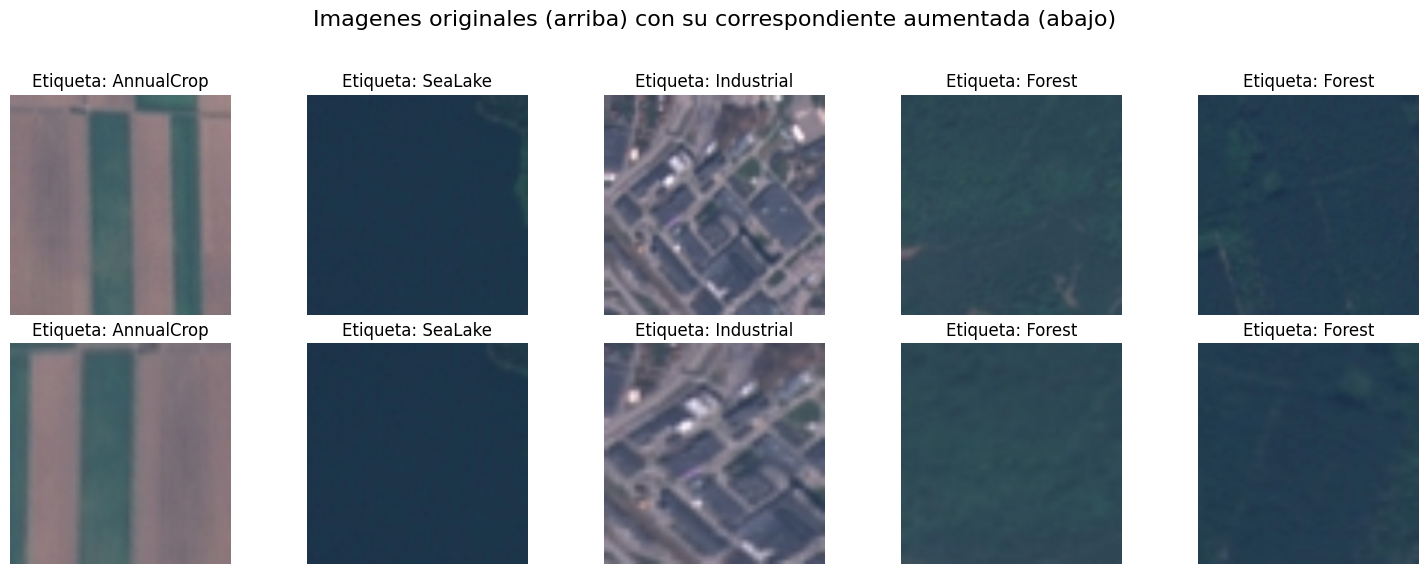

In [14]:
random_idx = random.sample(range(len(dataset["train"])), 5)
plot_subset = dataset["train"].select(random_idx)

raw_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=False))
raw_dataloader = DataLoader(raw_plot_subset, batch_size=5, shuffle=False)

aug_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=True))
aug_dataloader = DataLoader(aug_plot_subset, batch_size=5, shuffle=False)

# Get and unnormalize raw images
raw_batch = next(iter(raw_dataloader))
raw_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in raw_batch["pixel_values"]]

# Get and unnormalize augmented images
aug_batch = next(iter(aug_dataloader))
aug_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in aug_batch["pixel_values"]]

plot_labels = [id2label[int(x)] for x in raw_batch["label"]] * 2

# Plot images
show_image_grid(
    data={"images": raw_images + aug_images, "labels": plot_labels},
    title="Imagenes originales (arriba) con su correspondiente aumentada (abajo)",
    num_cols=5,
)

In [15]:
# Aplicamos las transformaciones
dataset["train"].set_transform(partial(transforms, train=True))
dataset["test"].set_transform(partial(transforms, train=False))

# Mostramos un ejemplo de la estructura.
print(dataset["train"][0])
print(dataset["test"][0]["pixel_values"].shape)

{'label': 0, 'pixel_values': tensor([[[-0.2513, -0.2513, -0.2513,  ...,  1.3584,  1.3584,  1.3584],
         [-0.2513, -0.2513, -0.2513,  ...,  1.3584,  1.3584,  1.3584],
         [-0.2513, -0.2513, -0.2513,  ...,  1.3584,  1.3584,  1.3584],
         ...,
         [ 1.2043,  1.2043,  1.2043,  ...,  1.6153,  1.6153,  1.6153],
         [ 1.2043,  1.2043,  1.2043,  ...,  1.6153,  1.6153,  1.6153],
         [ 1.2043,  1.2043,  1.2043,  ...,  1.6153,  1.6153,  1.6153]],

        [[-0.2325, -0.2325, -0.2325,  ...,  0.8704,  0.8704,  0.8704],
         [-0.2325, -0.2325, -0.2325,  ...,  0.8704,  0.8704,  0.8704],
         [-0.2325, -0.2325, -0.2325,  ...,  0.8704,  0.8704,  0.8704],
         ...,
         [ 0.8004,  0.8004,  0.8004,  ...,  1.1681,  1.1681,  1.1681],
         [ 0.8004,  0.8004,  0.8004,  ...,  1.1681,  1.1681,  1.1681],
         [ 0.8004,  0.8004,  0.8004,  ...,  1.1681,  1.1681,  1.1681]],

        [[ 0.0256,  0.0256,  0.0256,  ...,  0.7576,  0.7576,  0.7576],
         [ 0.025

## 4. Definición de las métricas de evaluación <a name="metrics"></a>

In [16]:
clf_metrics = evaluate.combine([
    MulticlassAccuracy(),  # Precisión multicategoría.
    evaluate.load("f1"), # Puede ser "micro", "macro" o "weighted". En este caso, "weighted" toma en cuenta el desbalanceo leve de clases.
    evaluate.load("precision"), # "marco" para clases desbalanceadas.
    evaluate.load("recall")
])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels, average="weighted")

## 5. Entrenamiento del modelo <a name="entrenamiento"></a>

In [17]:
training_args = TrainingArguments(
    output_dir=MODELS_DIR / MODEL_FOLDER,  
    overwrite_output_dir=True,  
    eval_strategy="epoch",  
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    eval_accumulation_steps=1, 
    learning_rate=5e-5,  
    num_train_epochs=1,  
    warmup_ratio=0.1,   
    save_strategy="best", 
    save_total_limit=1, 
    logging_strategy="epoch",  
    seed=RANDOM_SEED,  
    remove_unused_columns=False,  
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",
    dataloader_num_workers=4,
    report_to=[],
)

> 📝 <em><font color='Gray'>Nota:</font></em> Si no se estima o tiene una noción de los hiperparámetros, se pueden buscar con:
> ```python
> def optuna_hp_space(trial):
>     return {
>         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True),
>         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
>         "eval_accumulation_steps": trial.suggest_int("eval_accumulation_steps", 1, 8),
>         
>     }
> 
> def model_init(trial):
>     return AutoModelForImageClassification.from_pretrained(
>         CHECKPOINT,
>         num_labels=len(labels),
>         id2label=id2label,
>         label2id=label2id,
>         ignore_mismatched_sizes=True,  # Ignora tamaños de pesos que no coinciden (útil si se cambia el número de clases).
> )
> 
> trainer = Trainer(
>     model=None,   
>     args=training_args,
>     data_collator=data_collator,   
>     train_dataset=dataset['train'], 
>     eval_dataset=dataset['test'],   
>     processing_class=image_processor,
>     compute_metrics=compute_metrics,
>     model_init=model_init,  # Inicialización del modelo para Optuna.
>     callbacks=callback_list, 
> )
> 
> best_trial = trainer.hyperparameter_search(
>     direction="minimize",
>     backend="optuna",
>     hp_space=optuna_hp_space,
>     n_trials=5,
> )
> ```

In [18]:
data_collator = DefaultDataCollator()

callback_list = [EarlyStoppingCallback(early_stopping_patience=2), MLflowCallback()]

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    callbacks=callback_list
)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("transforms", transforms.transforms_to_string())
    mlflow.log_param("dataset_name", DATASET_NAME)
    mlflow.log_param("dataset_version", DATASET_VERSION)

    logger.info("Iniciando entrenamiento del modelo...")
    trainer.train()
    logger.info("Entrenamiento finalizado. Guardando el modelo...")

history = pd.DataFrame(trainer.state.log_history)
history.to_csv(MODELS_DIR / MODEL_FOLDER / HISTORY_FILENAME, index=False)
history

2025-06-14 20:38:49.898 | INFO     | __main__:<module>:6 - Iniciando entrenamiento del modelo...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.264600,2.192298,0.187500,0.141806,0.150164,0.187500


e:\Documentos\Git Repositories\vision-transformer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



2025-06-14 20:39:15.798 | INFO     | __main__:<module>:8 - Entrenamiento finalizado. Guardando el modelo...
🏃 View run inquisitive-croc-136 at: http://localhost:8080/#/experiments/1/runs/f0480b3604254736948339eeccdc37ec
🧪 View experiment at: http://localhost:8080/#/experiments/1


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.2646,14.507318,0.000017,1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,4,2.192298,0.1875,0.141806,0.150164,0.1875,11.2133,7.134,0.268,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.1842,3.971,0.159,3.254159e+15,2.264627


In [ ]:
logger.info("Evaluando el modelo...")
metrics = trainer.evaluate()
logger.info("Evaluación finalizada. Métricas:")

metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df.to_csv(MODELS_DIR / MODEL_FOLDER / METRICS_FILENAME, index=False)
metrics_df

In [ ]:
# Guardamos las predicciones del modelo en el conjunto de test
predictions_output = trainer.predict(dataset["test"])

# Probabilidades
y_probs = predictions_output.predictions

# Predicciones finales (argmax)
y_pred = np.argmax(y_probs, axis=1)

# Etiquetas reales
y_true = predictions_output.label_ids

results_df = pd.DataFrame(
    {
        "y_true": [id2label[i] for i in y_true],
        "y_pred": [id2label[i] for i in y_pred],
    }
)
results_df.to_csv(MODELS_DIR / MODEL_FOLDER / PREDICTIONS_FILENAME, index=False)

## 6. Resultados <a name="resultados"></a>

In [ ]:
history = pd.read_csv(MODELS_DIR / MODEL_FOLDER / HISTORY_FILENAME)
results_df = pd.read_csv(MODELS_DIR / MODEL_FOLDER / PREDICTIONS_FILENAME)
y_true = results_df["y_true"].values
y_pred = results_df["y_pred"].values

In [ ]:
plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    labels=sorted(set(y_true)),
    filename=CHECKPOINT.replace("/", "-") + "_confusion_matrix",
    dirpath=FIGURES_DIR / MODEL_FOLDER,
    show_as_percentaje=True
)

In [ ]:
# Filtramos solo las filas que tienen datos útiles
filtered_history = history.copy()
filtered_history = filtered_history[filtered_history["epoch"].notna()]

# Plot de pérdidas (loss)
plot_metric(
    filtered_history,
    x_col="epoch",
    y_cols=["loss", "eval_loss"],
    y_labels=["Pérdida de entrenamiento", "Pérdida de evaluación"],
    title="Pérdida por época",
    filename=CHECKPOINT.replace("/", "-") + "_loss_plot",
    dirpath=FIGURES_DIR / MODEL_FOLDER,
)

# Plot de accuracy
if "eval_accuracy" in filtered_history.columns:
    plot_metric(
        filtered_history[filtered_history["eval_accuracy"].notna()],
        x_col="epoch",
        y_cols=["eval_accuracy"],
        y_labels=["Accuracy de evaluación"],
        title="Accuracy por época",
        filename=CHECKPOINT.replace("/", "-") + "_accuracy_plot",
        dirpath=FIGURES_DIR / MODEL_FOLDER,
    )